In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math


#######
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes, self.expansion * planes, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


class BasicBlockW(nn.Module):
    def __init__(self, in_planes, out_planes, stride, drop_rate=0.0):
        super(BasicBlockW, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = drop_rate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                                                                padding=0, bias=False) or None

    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))

        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)


class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)

    @staticmethod
    def _make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)


class WideResNet(nn.Module):
    def __init__(self, depth=28, num_classes=10, widen_factor=10, drop_rate=0.0):
        super(WideResNet, self).__init__()
        n_channels = [16, 16 * widen_factor, 32 * widen_factor, 64 * widen_factor]
        assert ((depth - 4) % 6 == 0)
        n = int((depth - 4) / 6)
        block = BasicBlockW

        self.conv1 = nn.Conv2d(3, n_channels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)

        self.block1 = NetworkBlock(n, n_channels[0], n_channels[1], block, 1, drop_rate)

        self.block2 = NetworkBlock(n, n_channels[1], n_channels[2], block, 2, drop_rate)

        self.block3 = NetworkBlock(n, n_channels[2], n_channels[3], block, 2, drop_rate)

        self.bn1 = nn.BatchNorm2d(n_channels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(n_channels[3], num_classes)
        self.nChannels = n_channels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        return self.fc(out)

In [24]:
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib.image import imread
from mpl_toolkits import mplot3d
from matplotlib import gridspec
from PIL import Image
import io
from urllib.request import urlopen
# from skimage.segmentation import mark_boundaries

from tqdm.notebook import tqdm
import numpy as np
import requests
import torch

from sklearn.metrics import classification_report
from torch.utils.tensorboard import SummaryWriter

from torchvision import datasets, transforms

import torch

%matplotlib inline
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
import itertools
import numpy as np
from matplotlib import gridspec
from torch import nn
from tqdm import tqdm

from torch.utils.data import TensorDataset, DataLoader
import time
import matplotlib
matplotlib.use('pdf')


import seaborn; seaborn.set_style('whitegrid')



from keras.datasets import mnist
from keras.datasets import fashion_mnist

from sklearn.metrics import pairwise_distances

# from umap import UMAP
from apricot import FacilityLocationSelection

import keras
%pylab inline
import seaborn; seaborn.set_style('whitegrid')
import shap

from sklearn.linear_model import LogisticRegression
from shap import LinearExplainer
from apricot import FeatureBasedSelection

from torchvision.datasets import CIFAR10


Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [44]:
def train_on_batch(clf, x_batch, y_batch, opt, criterion):
    clf.train(True)

    opt.zero_grad()
    output = clf.forward(x_batch.to(device))

    loss = criterion(output, y_batch.to(device))
    loss.backward()

    accuracy = np.mean((y_batch.cpu().numpy() == output.argmax(1).cpu().numpy()))

    opt.step()
    return loss.cpu().item(), accuracy.item()

def epoch_train(loader, clf, criterion, opt):

    epoch_loss = np.array([])
    epoch_accuracy = np.array([])

    for it, (batch_of_x, batch_of_y) in enumerate(loader):
        batch_loss, batch_accuracy = train_on_batch(clf, batch_of_x.to(device), batch_of_y.to(device), opt, criterion)

        epoch_loss = np.append(epoch_loss, batch_loss)
        epoch_accuracy = np.append(epoch_accuracy, batch_accuracy)

    return np.mean(epoch_loss), np.mean(epoch_accuracy)



def test_on_batch(clf, x_batch, y_batch, opt, criterion):
    clf.eval()

    with torch.no_grad():

        output = clf.forward(x_batch.to(device))
        loss = criterion(output, y_batch.to(device))
        accuracy = np.mean((y_batch.cpu().numpy() == output.argmax(1).cpu().numpy()))

    return loss.cpu().item(), accuracy.item()


def epoch_test(loader, clf, criterion):

    epoch_loss = np.array([])
    epoch_accuracy = np.array([])

    for it, (batch_of_x, batch_of_y) in enumerate(loader):
        batch_loss, batch_accuracy = test_on_batch(clf, batch_of_x.to(device), batch_of_y.to(device), opt, criterion)

        epoch_loss = np.append(epoch_loss, batch_loss)
        epoch_accuracy = np.append(epoch_accuracy, batch_accuracy)

    return np.mean(epoch_loss), np.mean(epoch_accuracy)


def train(train_loader, test_loader, clf, criterion, opt, n_epochs=50):

    dict = {'time':np.array([]), 'train_loss':np.array([]), 'train_acc':np.array([]), 'test_loss':np.array([]), 'test_acc':np.array([])}
    
    start = time.time()
    
    for epoch in tqdm(range(n_epochs)):
        train_loss, train_acc = epoch_train(train_loader, clf, criterion, opt)
        test_loss, test_acc = epoch_test(test_loader, clf, criterion)

        dict['time'] = np.append(dict['time'], time.time() - start)
        dict['train_loss'] = np.append(dict['train_loss'], train_loss)
        dict['train_acc'] = np.append(dict['train_acc'], train_acc)
        dict['test_loss'] = np.append(dict['test_loss'], test_loss)
        dict['test_acc'] = np.append(dict['test_acc'], test_acc)

        print(f'[time {epoch + 1}] train loss: {train_loss:.3f}; train acc: {train_acc:.2f}; ' +
              f'test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')

    return dict





In [5]:

    
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.features = nn.Sequential()

        self.features.add_module('conv1', torch.nn.Conv2d(3, 32, kernel_size = 3, padding = 1))
        self.features.add_module('relu1', torch.nn.ReLU())
        self.features.add_module('pool1', torch.nn.MaxPool2d(kernel_size = 2))

        self.features.add_module('conv2', torch.nn.Conv2d(32, 64, kernel_size = 3, padding = 1))
        self.features.add_module('relu2', torch.nn.ReLU())
        self.features.add_module('pool2', torch.nn.MaxPool2d(kernel_size = 2))

        self.features.add_module('conv3', torch.nn.Conv2d(64, 128, kernel_size = 3, padding = 1))
        self.features.add_module('relu3', torch.nn.ReLU())
        self.features.add_module('pool3', torch.nn.MaxPool2d(kernel_size = 2))

        self.features.add_module('conv4', torch.nn.Conv2d(128, 256, kernel_size = 3, padding = 1))
        self.features.add_module('relu4', torch.nn.ReLU())
        self.features.add_module('pool4', torch.nn.MaxPool2d(kernel_size = 2))


        self.classifier = nn.Sequential()

        self.classifier.add_module('flatten', torch.nn.Flatten())

        self.classifier.add_module('linear1', torch.nn.Linear(256*2*2, 512))
        self.classifier.add_module('relu5', torch.nn.ReLU())

        self.classifier.add_module('linear2', torch.nn.Linear(512, 256))
        self.classifier.add_module('relu6', torch.nn.ReLU())

        self.classifier.add_module('linear3', torch.nn.Linear(256, 128))
        self.classifier.add_module('relu7', torch.nn.ReLU())

        self.classifier.add_module('linear4', torch.nn.Linear(128, 64))
        self.classifier.add_module('relu8', torch.nn.ReLU())

        self.classifier.add_module('linear5', torch.nn.Linear(64, 10))


    def forward(self, x):

        return self.classifier(self.features(x))

In [36]:
torch.cuda.set_device(0)
clf_cnn = ResNet50()
clf_cnn.to(device)
clf_cnn.device = device

In [41]:
batch_size = 128
mean = [0.4914, 0.4822, 0.4465]
std = [0.2470, 0.2435, 0.2616]

train_transform = transforms.Compose([
    # transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])


train_set = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [42]:

opt = torch.optim.Adam(clf_cnn.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()


In [45]:
n_epochs=25

res = train(train_loader, test_loader, clf_cnn, criterion, opt, n_epochs=n_epochs)

  4%|▍         | 1/25 [01:51<44:47, 112.00s/it]

[time 1] train loss: 0.800; train acc: 0.72; test loss: 0.795; test acc: 0.73


  8%|▊         | 2/25 [03:45<43:14, 112.79s/it]

[time 2] train loss: 0.667; train acc: 0.76; test loss: 0.626; test acc: 0.78


 12%|█▏        | 3/25 [05:38<41:21, 112.79s/it]

[time 3] train loss: 0.568; train acc: 0.80; test loss: 0.693; test acc: 0.76


 16%|█▌        | 4/25 [07:31<39:34, 113.09s/it]

[time 4] train loss: 0.505; train acc: 0.82; test loss: 0.513; test acc: 0.82


 20%|██        | 5/25 [09:24<37:41, 113.09s/it]

[time 5] train loss: 0.450; train acc: 0.84; test loss: 0.512; test acc: 0.82


 24%|██▍       | 6/25 [11:18<35:50, 113.19s/it]

[time 6] train loss: 0.415; train acc: 0.86; test loss: 0.518; test acc: 0.83


 28%|██▊       | 7/25 [13:10<33:53, 112.98s/it]

[time 7] train loss: 0.378; train acc: 0.87; test loss: 0.489; test acc: 0.84


 32%|███▏      | 8/25 [15:03<32:00, 112.97s/it]

[time 8] train loss: 0.340; train acc: 0.88; test loss: 0.437; test acc: 0.86


 36%|███▌      | 9/25 [16:56<30:05, 112.84s/it]

[time 9] train loss: 0.331; train acc: 0.88; test loss: 0.397; test acc: 0.86


 40%|████      | 10/25 [18:48<28:12, 112.81s/it]

[time 10] train loss: 0.292; train acc: 0.90; test loss: 0.397; test acc: 0.87


 44%|████▍     | 11/25 [20:41<26:18, 112.72s/it]

[time 11] train loss: 0.264; train acc: 0.91; test loss: 0.382; test acc: 0.87


 48%|████▊     | 12/25 [22:33<24:24, 112.62s/it]

[time 12] train loss: 0.252; train acc: 0.91; test loss: 0.408; test acc: 0.87


 52%|█████▏    | 13/25 [24:26<22:31, 112.61s/it]

[time 13] train loss: 0.226; train acc: 0.92; test loss: 0.406; test acc: 0.87


 56%|█████▌    | 14/25 [26:18<20:37, 112.54s/it]

[time 14] train loss: 0.215; train acc: 0.92; test loss: 0.409; test acc: 0.87


 60%|██████    | 15/25 [28:11<18:44, 112.49s/it]

[time 15] train loss: 0.201; train acc: 0.93; test loss: 0.368; test acc: 0.88


 64%|██████▍   | 16/25 [30:03<16:52, 112.47s/it]

[time 16] train loss: 0.178; train acc: 0.94; test loss: 0.426; test acc: 0.87


 68%|██████▊   | 17/25 [31:56<14:59, 112.50s/it]

[time 17] train loss: 0.165; train acc: 0.94; test loss: 0.399; test acc: 0.88


 72%|███████▏  | 18/25 [33:48<13:07, 112.52s/it]

[time 18] train loss: 0.156; train acc: 0.94; test loss: 0.389; test acc: 0.88


 76%|███████▌  | 19/25 [35:41<11:15, 112.55s/it]

[time 19] train loss: 0.168; train acc: 0.94; test loss: 0.385; test acc: 0.88


 80%|████████  | 20/25 [37:34<09:23, 112.60s/it]

[time 20] train loss: 0.132; train acc: 0.95; test loss: 0.416; test acc: 0.88


 84%|████████▍ | 21/25 [39:26<07:30, 112.63s/it]

[time 21] train loss: 0.126; train acc: 0.95; test loss: 0.393; test acc: 0.89


 88%|████████▊ | 22/25 [41:19<05:37, 112.61s/it]

[time 22] train loss: 0.115; train acc: 0.96; test loss: 0.396; test acc: 0.89


 92%|█████████▏| 23/25 [43:11<03:45, 112.56s/it]

[time 23] train loss: 0.114; train acc: 0.96; test loss: 0.383; test acc: 0.89


 96%|█████████▌| 24/25 [45:04<01:52, 112.54s/it]

[time 24] train loss: 0.104; train acc: 0.96; test loss: 0.390; test acc: 0.89


100%|██████████| 25/25 [46:56<00:00, 112.67s/it]

[time 25] train loss: 0.096; train acc: 0.97; test loss: 0.404; test acc: 0.89


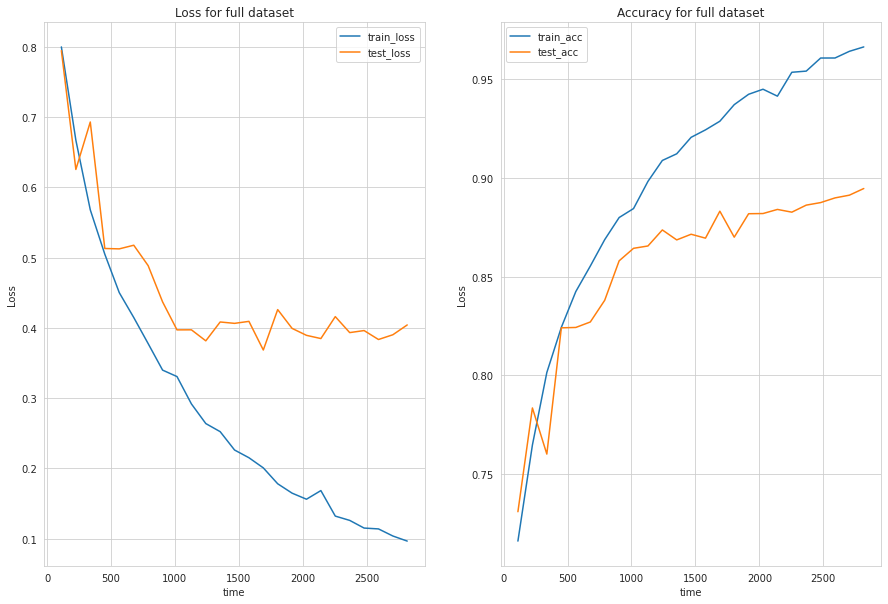

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

ax1.set_title('Loss for full dataset')
ax2.set_title('Accuracy for full dataset')

ax1.plot(res['time'], res['train_loss'], label='train_loss')
ax1.plot(res['time'], res['test_loss'], label='test_loss')

ax1.set_xlabel("time")
ax1.set_ylabel("Loss")
ax1.legend()



ax2.plot(res['time'], res['train_acc'], label='train_acc')
ax2.plot(res['time'], res['test_acc'], label='test_acc')

ax2.set_xlabel("time")
ax2.set_ylabel("Loss")
ax2.legend()



# -----------------------------------------

In [57]:
torch.cuda.set_device(0)
clf_cnn = ResNet50()
clf_cnn.to(device)
clf_cnn.device = device

In [58]:

batch_size = 128
mean = [0.4914, 0.4822, 0.4465]
std = [0.2470, 0.2435, 0.2616]

train_transform = transforms.Compose([
    # transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])


train_set = CIFAR10(root='./data', train=True, download=True, transform=train_transform)

test_set = CIFAR10(root='./data', train=False, download=True, transform=test_transform)



train_loader = DataLoader(train_set, batch_size=len(train_set))
test_loader = DataLoader(test_set, batch_size=batch_size)

X_train = next(iter(train_loader))[0].numpy()
y_train = next(iter(train_loader))[1].numpy()


Files already downloaded and verified
Files already downloaded and verified


In [59]:
n = 50000 #value of training set
X_train = X_train.reshape(X_train.shape[0], 3*32*32)
X_train_apricot, y_train_apricot = FacilityLocationSelection(n, verbose=True).fit_transform(X_train, y_train)
X_train_apricot = X_train_apricot.reshape(n, 3, 32, 32)


100%|██████████| 50.0k/50.0k [1:25:07<00:00, 9.79it/s]


In [60]:
tensor_x = torch.Tensor(X_train_apricot[:40000,:,:]) 
tensor_y = torch.Tensor(y_train_apricot[:40000]).type(torch.LongTensor)

train_set = TensorDataset(tensor_x,tensor_y)
train_loader = DataLoader(train_set, batch_size=batch_size)


In [61]:
opt = torch.optim.Adam(clf_cnn.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [62]:
n_epochs=40

res_sub_opt = train(train_loader, test_loader, clf_cnn, criterion, opt, n_epochs=n_epochs)

  2%|▎         | 1/40 [01:21<53:15, 81.94s/it]

[time 1] train loss: 1.509; train acc: 0.47; test loss: 1.548; test acc: 0.46


  5%|▌         | 2/40 [02:43<51:43, 81.67s/it]

[time 2] train loss: 1.055; train acc: 0.62; test loss: 1.204; test acc: 0.60


  8%|▊         | 3/40 [04:04<50:19, 81.61s/it]

[time 3] train loss: 0.819; train acc: 0.71; test loss: 1.225; test acc: 0.60


 10%|█         | 4/40 [05:26<48:59, 81.66s/it]

[time 4] train loss: 0.653; train acc: 0.77; test loss: 1.499; test acc: 0.59


 12%|█▎        | 5/40 [06:48<47:40, 81.73s/it]

[time 5] train loss: 0.548; train acc: 0.81; test loss: 1.353; test acc: 0.64


 15%|█▌        | 6/40 [08:10<46:21, 81.81s/it]

[time 6] train loss: 0.461; train acc: 0.84; test loss: 1.257; test acc: 0.68


 18%|█▊        | 7/40 [09:32<45:01, 81.87s/it]

[time 7] train loss: 0.380; train acc: 0.87; test loss: 1.274; test acc: 0.68


 20%|██        | 8/40 [10:54<43:42, 81.95s/it]

[time 8] train loss: 0.309; train acc: 0.89; test loss: 1.152; test acc: 0.70


 22%|██▎       | 9/40 [12:16<42:22, 82.03s/it]

[time 9] train loss: 0.256; train acc: 0.91; test loss: 1.339; test acc: 0.70


 25%|██▌       | 10/40 [13:39<41:02, 82.08s/it]

[time 10] train loss: 0.214; train acc: 0.92; test loss: 1.243; test acc: 0.72


 28%|██▊       | 11/40 [15:01<39:42, 82.15s/it]

[time 11] train loss: 0.175; train acc: 0.94; test loss: 1.314; test acc: 0.73


 30%|███       | 12/40 [16:23<38:21, 82.18s/it]

[time 12] train loss: 0.138; train acc: 0.95; test loss: 1.624; test acc: 0.72


 32%|███▎      | 13/40 [17:45<36:59, 82.21s/it]

[time 13] train loss: 0.122; train acc: 0.96; test loss: 1.233; test acc: 0.75


 35%|███▌      | 14/40 [19:08<35:39, 82.27s/it]

[time 14] train loss: 0.098; train acc: 0.96; test loss: 1.487; test acc: 0.73


 38%|███▊      | 15/40 [20:30<34:17, 82.29s/it]

[time 15] train loss: 0.098; train acc: 0.97; test loss: 1.343; test acc: 0.75


 40%|████      | 16/40 [21:52<32:54, 82.28s/it]

[time 16] train loss: 0.085; train acc: 0.97; test loss: 1.358; test acc: 0.75


 42%|████▎     | 17/40 [23:15<31:34, 82.37s/it]

[time 17] train loss: 0.082; train acc: 0.97; test loss: 1.368; test acc: 0.76


 45%|████▌     | 18/40 [24:37<30:12, 82.39s/it]

[time 18] train loss: 0.075; train acc: 0.97; test loss: 1.726; test acc: 0.72


 48%|████▊     | 19/40 [26:00<28:50, 82.40s/it]

[time 19] train loss: 0.075; train acc: 0.98; test loss: 1.498; test acc: 0.76


 50%|█████     | 20/40 [27:22<27:29, 82.46s/it]

[time 20] train loss: 0.070; train acc: 0.98; test loss: 1.230; test acc: 0.78


 52%|█████▎    | 21/40 [28:45<26:06, 82.44s/it]

[time 21] train loss: 0.056; train acc: 0.98; test loss: 1.387; test acc: 0.78


 55%|█████▌    | 22/40 [30:07<24:43, 82.42s/it]

[time 22] train loss: 0.059; train acc: 0.98; test loss: 1.502; test acc: 0.76


 57%|█████▊    | 23/40 [31:30<23:21, 82.42s/it]

[time 23] train loss: 0.055; train acc: 0.98; test loss: 1.431; test acc: 0.76


 60%|██████    | 24/40 [32:52<21:58, 82.43s/it]

[time 24] train loss: 0.048; train acc: 0.98; test loss: 1.392; test acc: 0.77


 62%|██████▎   | 25/40 [34:14<20:36, 82.43s/it]

[time 25] train loss: 0.055; train acc: 0.98; test loss: 1.612; test acc: 0.74


 65%|██████▌   | 26/40 [35:37<19:13, 82.41s/it]

[time 26] train loss: 0.047; train acc: 0.98; test loss: 1.473; test acc: 0.77


 68%|██████▊   | 27/40 [36:59<17:51, 82.43s/it]

[time 27] train loss: 0.045; train acc: 0.98; test loss: 1.343; test acc: 0.78


 70%|███████   | 28/40 [38:22<16:28, 82.38s/it]

[time 28] train loss: 0.041; train acc: 0.99; test loss: 1.408; test acc: 0.77


 72%|███████▎  | 29/40 [39:44<15:07, 82.49s/it]

[time 29] train loss: 0.046; train acc: 0.98; test loss: 1.420; test acc: 0.78


 75%|███████▌  | 30/40 [41:07<13:44, 82.47s/it]

[time 30] train loss: 0.039; train acc: 0.99; test loss: 1.488; test acc: 0.78


 78%|███████▊  | 31/40 [42:29<12:21, 82.40s/it]

[time 31] train loss: 0.043; train acc: 0.98; test loss: 1.410; test acc: 0.77


 80%|████████  | 32/40 [43:51<10:59, 82.43s/it]

[time 32] train loss: 0.040; train acc: 0.99; test loss: 1.454; test acc: 0.77


 82%|████████▎ | 33/40 [45:14<09:36, 82.40s/it]

[time 33] train loss: 0.034; train acc: 0.99; test loss: 1.402; test acc: 0.78


 85%|████████▌ | 34/40 [46:36<08:14, 82.39s/it]

[time 34] train loss: 0.038; train acc: 0.99; test loss: 1.227; test acc: 0.80


 88%|████████▊ | 35/40 [47:59<06:52, 82.41s/it]

[time 35] train loss: 0.038; train acc: 0.99; test loss: 1.311; test acc: 0.78


 90%|█████████ | 36/40 [49:21<05:29, 82.45s/it]

[time 36] train loss: 0.033; train acc: 0.99; test loss: 1.290; test acc: 0.79


 92%|█████████▎| 37/40 [50:44<04:07, 82.50s/it]

[time 37] train loss: 0.036; train acc: 0.99; test loss: 1.357; test acc: 0.79


 95%|█████████▌| 38/40 [52:06<02:44, 82.48s/it]

[time 38] train loss: 0.023; train acc: 0.99; test loss: 1.398; test acc: 0.79


 98%|█████████▊| 39/40 [53:29<01:22, 82.52s/it]

[time 39] train loss: 0.028; train acc: 0.99; test loss: 1.588; test acc: 0.77


100%|██████████| 40/40 [54:51<00:00, 82.29s/it]

[time 40] train loss: 0.034; train acc: 0.99; test loss: 1.348; test acc: 0.79


Text(0, 0.5, 'Accuracy')

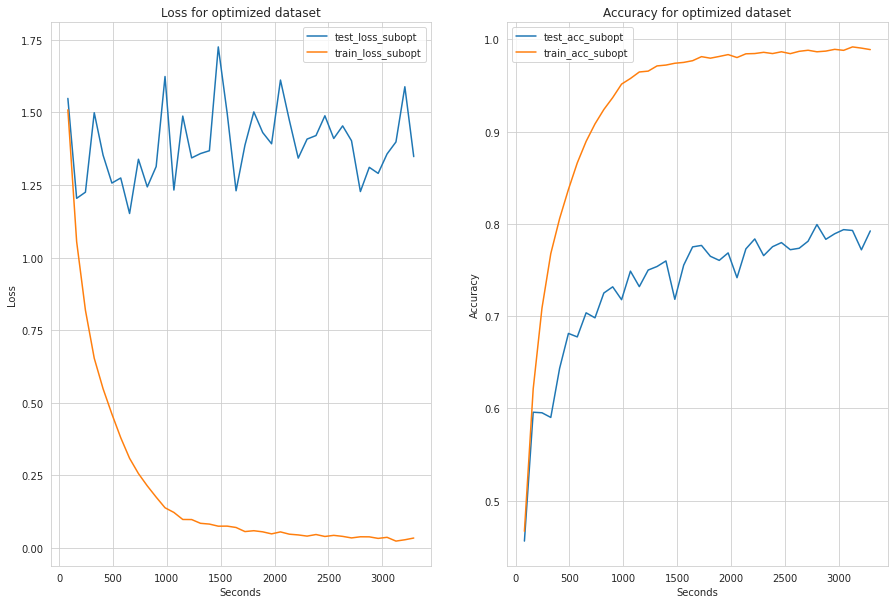

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

ax1.set_title('Loss for optimized dataset')
ax2.set_title('Accuracy for optimized dataset')


ax1.plot(res_sub_opt['time'], res_sub_opt['test_loss'], label='test_loss_subopt')
ax1.plot(res_sub_opt['time'], res_sub_opt['train_loss'], label='train_loss_subopt')

ax1.legend()

ax2.plot(res_sub_opt['time'], res_sub_opt['test_acc'], label='test_acc_subopt')
ax2.plot(res_sub_opt['time'], res_sub_opt['train_acc'], label='train_acc_subopt')

ax2.legend()

# ax1.plot(res['time'], res['test_loss'], label='test_loss_uniform')
# ax1.legend()


# ax2.plot(res['time'], res['test_acc'], label='test_acc_uniform')
# ax2.legend()


ax1.set_xlabel("Seconds")
ax1.set_ylabel("Loss")

ax2.set_xlabel("Seconds")
ax2.set_ylabel("Accuracy")

Text(0, 0.5, 'Accuracy')

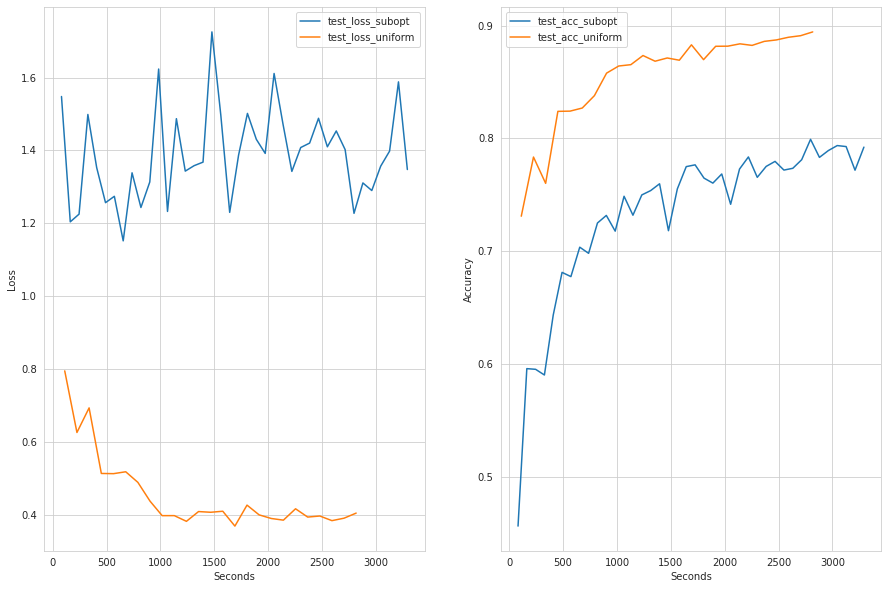

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))


ax1.plot(res_sub_opt['time'], res_sub_opt['test_loss'], label='test_loss_subopt')
ax1.legend()

ax2.plot(res_sub_opt['time'], res_sub_opt['test_acc'], label='test_acc_subopt')
ax2.legend()

ax1.plot(res['time'], res['test_loss'], label='test_loss_uniform')
ax1.legend()


ax2.plot(res['time'], res['test_acc'], label='test_acc_uniform')
ax2.legend()


ax1.set_xlabel("Seconds")
ax1.set_ylabel("Loss")

ax2.set_xlabel("Seconds")
ax2.set_ylabel("Accuracy")